# Startup -- CTR Template

In [1]:
import peakutils as pk
from ipywidgets import interact, fixed
import edoxrd as xrd

%matplotlib inline
%config InlineBackend.figure_formats = set(['png']) 

Specify the name of the main sample you want to look at, and the directory within which it is found.

In [2]:
d = './example_data/'
%ls {d} # should work on Windows too!

e16014_01_-103_KTO_RSM_2-Theta.asc* e16014_07_t2t_001.ras*
e16014_02_-103_PTO_RSM_2-Theta.asc* e16014_09_t2t_002.ras*


Have a look at the `.ras` files that can be read within the specified directory (untested on Windows -- figure out the corresponding commands if these don't work!):

In [4]:
# Linux/Mac OS
files = !ls {d} | grep '_00[1-9]' | grep '.ras'
# Windows
# files = !dir {d} | find '_00[1-9]' | find '.ras'
for fname in files: print fname

e16014_07_t2t_001.ras
e16014_09_t2t_002.ras


## Plot raw data

The cell below plots data in the `d` you specified before, i.e. what's listed above. Adjust the number of subplots in `plt.subplots` depending on the number of files you have.

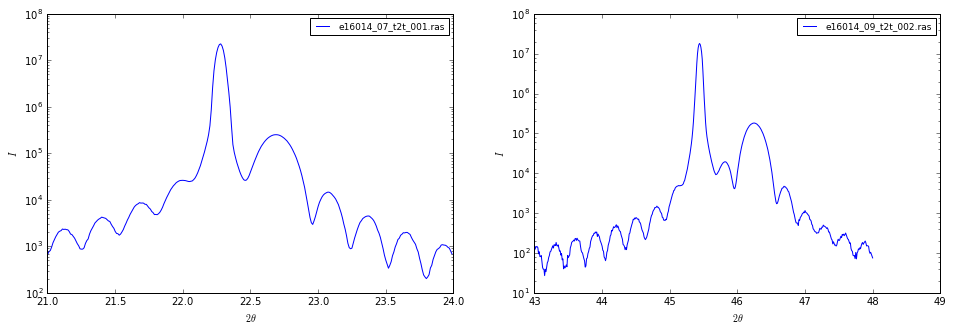

In [6]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax = ax.flatten()
for i in range(len(files)):
    ax[i].plot(*xrd.read_data(files[i],d),label=files[i])
    ax[i].set_xlabel(r'$2\theta$')
    ax[i].set_ylabel(r'$I$')
    ax[i].set_yscale('log')
    ax[i].legend(fontsize=9)

## Simulations

Have again a look at what's in the specified directory, and see what index corresponds to each datafile in the `files` list, so that you can choose it for further analysis:

In [8]:
for index,fname in enumerate(files): print('{0}  {1}').format(index,fname)

0  e16014_07_t2t_001.ras
1  e16014_09_t2t_002.ras


In [9]:
dset = files[1]

#### Estimate out-of-plane lattice parameter (try to use a high-order reflection for better precision, e.g. 002):

This just finds the Film peak and calculates the lattice parameter corresponding to it.

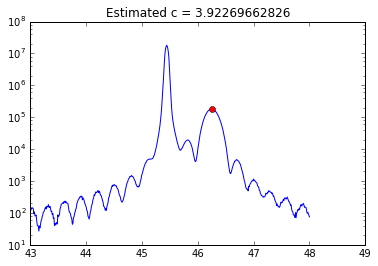

In [10]:
xdata, ydata = xrd.read_data(dset,d) 

# Find indices of film peak (i.e. second most intense in ydata)
idxs = pk.indexes(ydata, thres=1e-6, min_dist=10) 
film_peak = ydata[idxs].argsort()[::-1][1]
peak_x, peak_y = xdata[idxs][film_peak], ydata[idxs][film_peak]

# Some calc
theta = np.deg2rad(peak_x/2) # Theta_bragg of Film peak
wave = 1.5406 # Cu Ka1

c = wave/(2*np.sin(theta)) # Braggs law for 001; recall c=d_001
c = c*2 # Change multiplier or equation depending on reflection!

# Plot
plt.plot(xdata,ydata)
plt.plot(peak_x, peak_y, 'o', c='red')
plt.yscale('log')
plt.title('Estimated c = {0}'.format(c)) 
plt.show()

Check that the estimated **c** makes sense, you need to change the multiplier above (see comment) depending on the order of the reflection chosen (00*what?*).

#### Estimate thickness from Laue oscillations:

In [11]:
for index,fname in enumerate(files): print('{0}  {1}').format(index,fname)

0  e16014_07_t2t_001.ras
1  e16014_09_t2t_002.ras


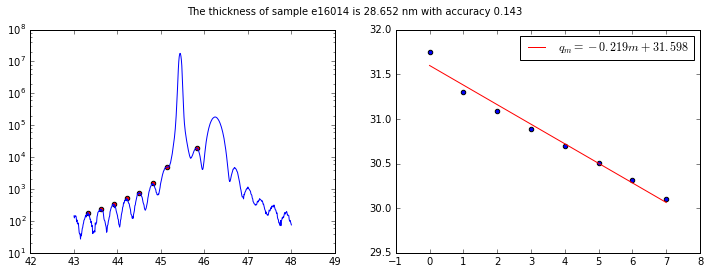

In [12]:
dset = files[1]
t = xrd.calc_thickness(dset, d, threshold=1e-5, distance=15, side='l')

#### Simulate starting from previous results:

In [13]:
dset = files[1]

The possible Film and Substrate materials and their data are contained within the `mat_dict` function:

In [14]:
xrd.mat_dict()[0].keys()

['PTO', 'STO', 'SRO_t', 'DSO', 'KTO', 'MTO', 'SRO_b']

If you want to add one, have a look at the `data/atom_positions` and `data/material_parameters` files; fractional atomic positions and lattice parameter for the new material to be added need to be input there. The format is specified within the datafile.

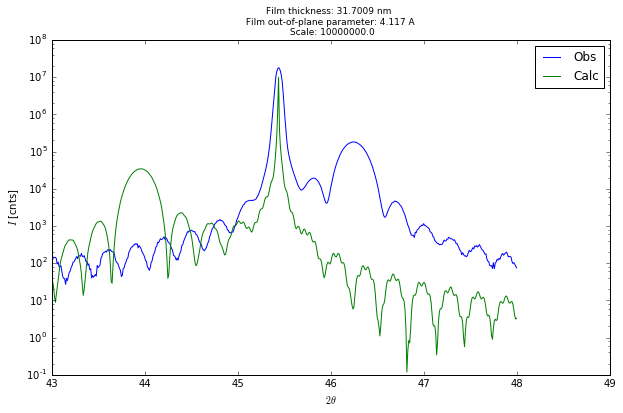

In [15]:
@interact(sub='KTO', film='PTO', Nfilm=(0,300,0.1), c_film=(3.9, 4.2, 0.001), scale=(1e5,1e8,1e6),
         continuous_update=False)
def plt_ctr(sub, film, Nfilm=t/(0.1*c), c_film=c, scale=1e7):
    xdata, I = xrd.calc_ctr(dset, d, sub, film, Nfilm, c_film)
    plt.figure(figsize=(10,6))
    plt.plot(*xrd.read_data(dset,d), label='Obs')
    plt.plot(xdata, I.real, label='Calc')
    plt.yscale('log')
    plt.ylabel(r'$I$ [cnts]')
    plt.xlabel(r'$2\theta$')
    plt.legend()
    plt.title('Film thickness: {0} nm \n Film out-of-plane parameter: {1} A \n Scale: {2}'\
              .format(Nfilm*c_film/10, c_film, scale), fontsize=9)